In [ ]:
#pip install pre-reco-utils
#pip install cornac
#pip install torch

In [1]:
#Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm
import cornac
import torch
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.recommender.cornac.cornac_utils import predict_ranking
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


# Data Exploration

In [2]:
#Importing the dataset
data = pd.read_csv('retail.csv')

In [3]:
#checking our dataframe
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
#Getting information about the dataset, namely the number of rows, types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
#Converting the InvoiceDate into a datetime object, so it can be easily used in the future
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Changing the type of the variable CustomerID
data = data.astype({'CustomerID': object})

In [6]:
#some interesting findings can be extracted even from this simple statistical analysis that we will explore further below
data.describe(include = 'all', datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.0,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372.0,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841.0,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983.0,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156151552,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,NaN,NaN


In [7]:
#Seems a legit case for the Unit Price to be negative. Nevertheless, it does not appear to be usefull for our purpose
data[data["UnitPrice"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [8]:
#Negative quantities seem to appear in two situations: 
#1. Returns (which are still a interaction)
#2. Special StockCode events (Manual, SAMPLES, printing smudges/thrown away)
data[data["Quantity"]<0].sort_values("Quantity")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
...,...,...,...,...,...,...,...,...
240697,C558112,22796,PHOTO FRAME 3 CLASSIC HANGING,-1,2011-06-26 16:08:00,9.95,17114,United Kingdom
240696,C558112,23091,ZINC HERB GARDEN CONTAINER,-1,2011-06-26 16:08:00,6.25,17114,United Kingdom
240694,C558112,82486,WOOD S/3 CABINET ANT WHITE FINISH,-1,2011-06-26 16:08:00,8.95,17114,United Kingdom
242447,C558347,S,SAMPLES,-1,2011-06-28 14:47:00,9.90,NaN,United Kingdom


In [9]:
#Cases that according to the metadata correspond to returns, being that we will explain later how to deal with this
data[data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [10]:
#Some more codes not corresponding to products, but that, once more, are not relevant for our purpose
data[~data["StockCode"].apply(lambda x: True if x[:-2].isdecimal() else False)]["StockCode"].value_counts()

POST            1256
DOT              710
M                571
C2               144
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
gift_0001_20      10
gift_0001_10       9
gift_0001_30       8
DCGS0003           5
PADS               4
gift_0001_50       4
B                  3
gift_0001_40       3
DCGS0070           2
DCGS0069           2
DCGS0076           2
m                  1
DCGS0066P          1
DCGS0055           1
DCGS0068           1
DCGS0067           1
DCGS0071           1
DCGS0004           1
DCGS0057           1
DCGS0072           1
DCGS0073           1
DCGS0074           1
Name: StockCode, dtype: int64

In [11]:
#As seen previously, the dataset contains missing values. Let us look into those in more detail.
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
#Firstly, we can start to see if when a Description is missing, the same happens for the CustomerID.
#We can indeed observe that this occurs.
data[data.Description.isna()]["CustomerID"].value_counts()

Series([], Name: CustomerID, dtype: int64)

In [13]:
#Analysing some entries whose Description is missing
data[data.Description.isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom


In [14]:
#Analysing some entries whose CustomerID is missing
data[data.CustomerID.isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


In [15]:
#Checking if we have duplicated values.
#We can see that we indeed have them, so we need to investigate them further.
data.duplicated().value_counts()

False    536641
True       5268
dtype: int64

In [16]:
#Getting the information of 3 different entries which are duplicated.
data[data.duplicated()].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom


In [17]:
#Using that information to access the first case, to analyse it better.
#There seem to exist in fact duplicates, but let us look at the order as a whole.
data[(data["InvoiceNo"]=="536409") & (data["StockCode"]=="21866")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom


In [18]:
#By looking at the order, it seems that other items are also purchased twice in the same order, for instance:
#"5 STRAND GLASS NECKLACE CRYSTAL" is purchased more than once: firstly, 3 units, then 1 and finally 2.
#Thus, it seems that the user may be able to add an item to the shopping cart in different quantities, but once he adds it, if he tries to add it again, it will count as another row. 
#Based on this, there doesn't seem to exist duplicates in the "true" sense
data[(data["InvoiceNo"]=="536409")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2010-12-01 11:45:00,6.35,17908,United Kingdom
484,536409,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-01 11:45:00,3.75,17908,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
486,536409,22785,SQUARECUSHION COVER PINK UNION FLAG,1,2010-12-01 11:45:00,6.75,17908,United Kingdom
487,536409,22975,SPACEBOY CHILDRENS EGG CUP,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
488,536409,22972,CHILDREN'S SPACEBOY MUG,1,2010-12-01 11:45:00,1.65,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
490,536409,22568,FELTCRAFT CUSHION OWL,1,2010-12-01 11:45:00,3.75,17908,United Kingdom
491,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
492,536409,22664,TOY TIDY DOLLY GIRL DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom


In [19]:
#Checking if each product only has 1 description.
#We can see that there are some cases where this doesn't happen. Lets explore this further.
data[data["Description"].notna()].groupby("StockCode")["Description"].unique().apply(lambda x: len (x)).value_counts()

1    3308
2     517
3      98
4      26
5       5
6       2
7       1
8       1
Name: Description, dtype: int64

In [20]:
#After looking with more detail, we found that the products which have more than one description are cases just like this one, due to to misspelled words, synonyms or punctuation
data.groupby("StockCode").Description.value_counts().iloc[50:55]

StockCode  Description                      
16054      POPART RECT PENCIL SHARPENER ASST     34
16151A     FLOWERS HANDBAG blue and orange        3
16156L     WRAP CAROUSEL                         14
           WRAP, CAROUSEL                         4
16156S     WRAP PINK FAIRY CAKES                167
Name: Description, dtype: int64

In [21]:
#Checking if each product only has 1 price registered.
#We can see that this isn't the case. 
#Nevertheless, we consider this not an impossible case, given that these changes in price can be due to promotions, price seasonality, or even permanent changes
data[data["UnitPrice"]>0].groupby("StockCode")["UnitPrice"].unique().apply(lambda x: len (x)).value_counts().sort_index()

1      561
2      533
3      822
4      866
5      532
6      292
7      158
8       71
9       36
10      23
11      20
12      10
13       3
14       1
15       2
16       1
26       1
30       1
59       1
75       1
113      1
259      1
686      1
Name: UnitPrice, dtype: int64

In [22]:
#Distinguish our variables into metric, non-metric and datetime, to auxiliate in the visual analysis.
metric_features = ['Quantity', 'UnitPrice']
date_feature = ['InvoiceDate']
non_metric_features = data.columns.drop(metric_features).drop(date_feature)

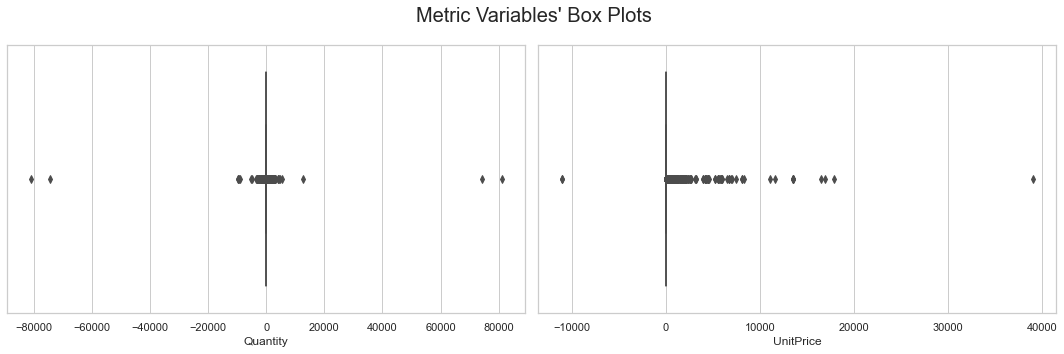

In [23]:
#starting by observing the distribution of the metric variables

#changing the background
sns.set()
sns.set_style("whitegrid")

#defining the number of plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#plotting each boxplot
for ax, features in zip(axes.flatten(), metric_features):
    sns.boxplot(x=data[features], ax=ax)
    
plt.suptitle("Metric Variables' Box Plots", fontsize=20)

#Adjusting the "visual" aspect of the plots
plt.tight_layout()

plt.show()

#We can, once more, see some interesting behaviours:
#1.We have negative values in the Quantity variable, while the highest value surpasses the 80,000 units
#2.We have negative values in the UnitPrice, while the highest value is almost 40,000

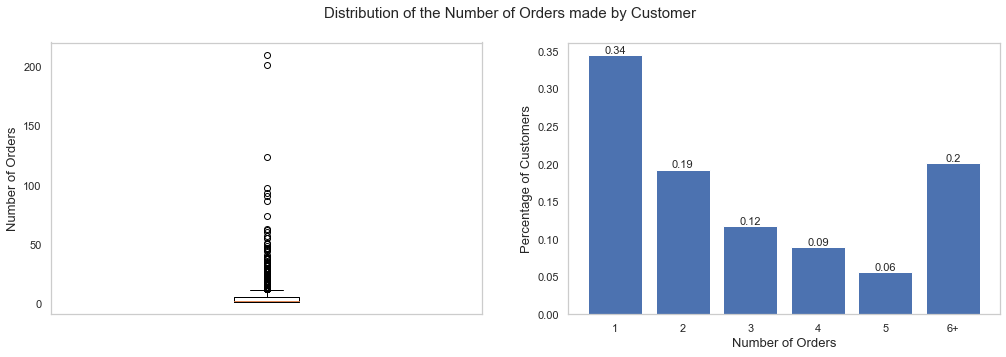

65.57% of the customers have bought more than once.


In [24]:
#We will now analyse the behavior of the customers, in what concerns the number of orders made by each.

#Creating an auxiliar dataframe to get the one row for each combination of InvoiceNo and CustomerID.
#Note that we computed this taking out the missing values for the CustomerID, so those entries don't mislead our findings (e.g., leaving the NaNs would meaning that each one would count as a separate Customer,and thus influence the results obtained).
df1 = pd.DataFrame(data[(~data.CustomerID.isna())&(~data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False))].groupby('InvoiceNo')['CustomerID'].unique())

#Seeing how many times each CustomerID appears
data1 = df1['CustomerID'].value_counts().sort_index()

#Normalizing our values and putting the customers who bought more than 5 times in the same "category"/bin
data2 = data1.value_counts(normalize=True).sort_index()[:5]
data2[6] = data1.value_counts(normalize=True).sort_index()[5:].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
barplot = ax2.bar(data2.index, data2.values)

ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel('Number of Orders', size=13)

ax2.set_xticks(list(range(1,7)))
ax2.set_xticklabels(list(range(1,6)) +['6+'])
ax2.set_xlabel('Number of Orders', size=13)
ax2.set_ylabel('Percentage of Customers', size=13)
fig.suptitle("Distribution of the Number of Orders made by Customer", size=15)

ax1.grid(False)
ax2.grid(False)

for rect in barplot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(float(height),2), ha='center', va='bottom', fontsize=11)

plt.show()
print("{0:.2f}% of the customers have bought more than once.".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

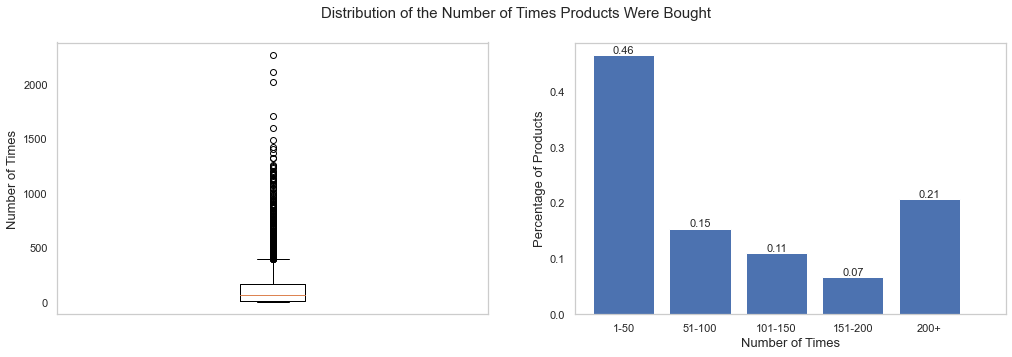

53.61% of the products were bought more than 50 times.


In [25]:
#We will now see the distribution of the number of times each product is bought.

#Making an auxiliar dataframe, storing the number of times each product was bought
data1 = data[~data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False)]['StockCode'].value_counts().sort_index()

#Normalizing the values and joining them by bins
data2 = data1.value_counts(normalize=True).sort_index()[:5]
data2[1] = data1.value_counts(normalize=True).sort_index()[:50].sum()
data2[2] = data1.value_counts(normalize=True).sort_index()[50:100].sum()
data2[3] = data1.value_counts(normalize=True).sort_index()[100:150].sum()
data2[4] = data1.value_counts(normalize=True).sort_index()[150:200].sum()
data2[5] = data1.value_counts(normalize=True).sort_index()[200:].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
barplot = ax2.bar(data2.index, data2.values)

ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel('Number of Times', size=13)

ax2.set_xticks(list(range(1,7)))
ax2.set_xticklabels(list(range(1,6)) +['6+'])
ax2.set_xlabel('Number of Times', size=13)
ax2.set_ylabel('Percentage of Products', size=13)
fig.suptitle("Distribution of the Number of Times Products Were Bought", size=15)

ax2.set_xticks(list(range(1,6)))
ax2.set_xticklabels(['1-50','51-100','101-150','151-200','200+'])

ax1.grid(False)
ax2.grid(False)

for rect in barplot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(float(height),2), ha='center', va='bottom', fontsize=11)

plt.show()
print("{0:.2f}% of the products were bought more than 50 times.".format(100*data2[1:].sum()))

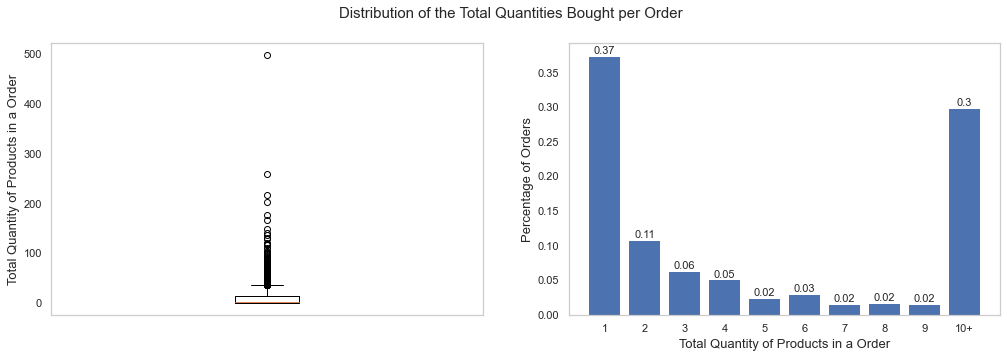

In [26]:
#We will now see the distribution of the number of total quantitites bought per order
#Note that we exclude cancelations/returns and orders whose Quantity is non-positive

#Getting the Sums of the Quantity per order and seeing how many times each ocurrs.
data1 = data[(~data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False))&(data["Quantity"]>0)].groupby("InvoiceNo")['Quantity'].sum().value_counts().sort_index()

#Separating into 2 groups
data2 = data1.value_counts(normalize=True).sort_index()[:10]
data2[10] = data1.value_counts(normalize=True).sort_index()[9:].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
barplot = ax2.bar(data2.index, data2.values)

ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel('Total Quantity of Products in a Order', size=13)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10))+['10+'])
ax2.set_xlabel('Total Quantity of Products in a Order', size=13)
ax2.set_ylabel('Percentage of Orders', size=13)
fig.suptitle("Distribution of the Total Quantities Bought per Order", size=15)

ax1.grid(False)
ax2.grid(False)

for rect in barplot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(float(height),2), ha='center', va='bottom', fontsize=11)

plt.show()

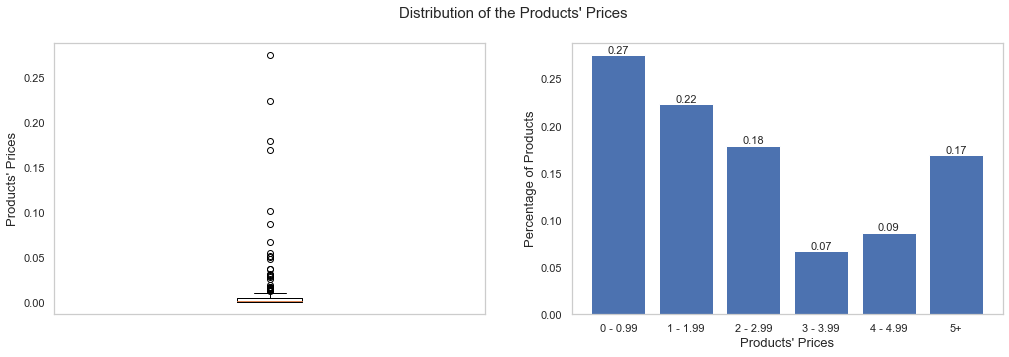

In [27]:
#We will now see, for all the products sold, the distribution of the UnitPrices

#Giving that the same StockCode can have different prices, we chose to use for our analysis the most frequent one.
price1 = data[['StockCode', 'UnitPrice', 'Quantity']].groupby(['StockCode', 'UnitPrice'], as_index=False).count()
price2 = price1.groupby(['StockCode'], as_index=False)['Quantity'].max()
price3 = price2.merge(price1, left_on=['StockCode', 'Quantity'], right_on=['StockCode', 'Quantity'])
price_final = price3.groupby(['StockCode', 'Quantity'], as_index=False)['UnitPrice'].max()

#Seeing how many times (in percentual terms) each price occurs and storing the results by intervals
data1 = price_final['UnitPrice'].value_counts(normalize=True).sort_index()
data1[0.04] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[0:0.99].sum()
data1[0.06] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[1:1.99].sum()
data1[0.08] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[2:2.99].sum()
data1[0.10] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[3:3.99].sum()
data1[0.12] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[4:4.99].sum()
data1[0.14] = price_final['UnitPrice'].value_counts(normalize=True).sort_index()[5:].sum()

values_series = pd.Series([data1[0.04],data1[0.06],data1[0.08],data1[0.10],data1[0.12],data1[0.14]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
barplot = ax2.bar(values_series.index,values_series.values)

ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel("Products' Prices", size=13)

ax2.set_xticks(list(range(0,6)))
ax2.set_xticklabels(['0 - 0.99','1 - 1.99','2 - 2.99','3 - 3.99','4 - 4.99','5+'])
ax2.set_xlabel("Products' Prices", size=13)
ax2.set_ylabel('Percentage of Products', size=13)
fig.suptitle("Distribution of the Products' Prices", size=15)

ax1.grid(False)
ax2.grid(False)

for rect in barplot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(float(height),2), ha='center', va='bottom', fontsize=11)

plt.show()

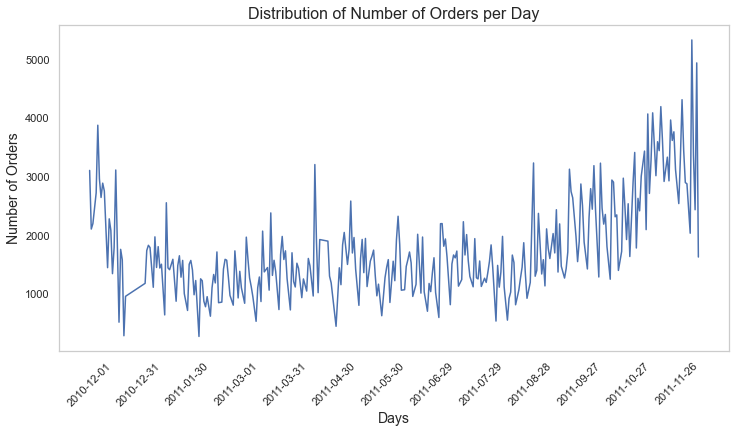

In [28]:
#We will now see the distribution of the number orders per day

#Getting an auxiliar dataframe to count the number of times each InvoiceDate appears
df = pd.DatetimeIndex(data['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))

plt.plot(df.index, df.values, linestyle="-")
plt.xticks(np.arange(df.index[0], df.index[-1], pd.to_timedelta(30, unit='d')), rotation=45)
plt.xlabel('Days', size=14)
plt.ylabel('Number of Orders', size=14)
plt.title('Distribution of Number of Orders per Day', size=16)
plt.grid(False)

plt.show()

## Clean data

### Missing Values

In [29]:
#Excluding from our analysis all the entries whose CustomerID is missing, as these are not pertinent for creating a recommendation system, as we can not keep track of their purchases (due to being unregistered customers)
data=data[data["CustomerID"].notna()]

### Non Products 

In [30]:
#Dealing with the Non-Product StockCode's which were detected previously, as they are not relevant for our purpose
data=data[~data["StockCode"].apply(lambda x: True if len(x)==1 else False)]
data=data[data["StockCode"].apply(lambda x: True if x[:-2].isdecimal() else False)]

In [31]:
#Dealing with the Cancellations.
#As we know that when a customer cancels/returns part of/all his order, this is added to the database, we have to find a way to deal with these cases.
#We don't want to keep the entries correspondent to cancellations, when we have the respective purchase present in the dataset, because that would lead to bias in the results (or to make this interaction have twice the weight, or to cancel out the interaction all together, depending on the method chosen to compute the "Preference")
#Being this said, we decided to only keep the cancelations whose order was prior to our dataset. This way, we can still "have access" to an interaction the client made and are not incurring into any bias.

#Creating an auxiliar list, to store the indices of the cancellations we wish to keep.
stored_inds=[]

#Crating a dataframe only with the entries which correspond to returns/cancelations, and leaving out the ones whose CustomerID is missing
data_returns=data[data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False)].dropna(subset=["CustomerID"])

#Filtering the dataset to find only the customers for who we have a cancellation in our dataset.
data_returns_users=data[data["CustomerID"].isin(data_returns["CustomerID"].unique())]

#From those, going over each StockCode, InvoiceDate and CustomerID (and index)
for ind, value in data_returns[["StockCode", "InvoiceDate", "CustomerID"]].iterrows():
    
    #Getting the customer's orders with the same product, which are not cancellations. 
    selection_data=data_returns_users[(data_returns_users["CustomerID"]==value["CustomerID"])&(data_returns_users["StockCode"]==value["StockCode"]) &(~data_returns_users.InvoiceNo.str.contains("C"))]
    
    #We have to use "try", because if none are found other than the cancelation, it gives an error
    try:
        #Check if the firt order's date if after the one from the cancelation/return. If so, store the index of this return.
        if selection_data.iloc[0]["InvoiceDate"]>value["InvoiceDate"]:
            stored_inds.append(ind)
    except:
        continue

#Selecting the indexes of the cancelations which we do not intend to keep and losing them.
inds_returns_to_drop=[i for i in data[(data["InvoiceNo"].apply(lambda x: True if x[0]=="C" else False))].index if i not in stored_inds ]
data.drop(inds_returns_to_drop, axis=0, inplace=True)

In [32]:
#Deleting the column relative to the customer's country, given that we will not use it.
data.drop("Country",axis=1, inplace=True)

# Contruction of data

## Separate Users for the General Model vs Cold Start Model

In [33]:
#We will reduce the sparcity of our user-items matrix

#Starting by seeing the current number of users and items and the consequent sparcity.
n_users = data['CustomerID'].nunique()
n_items = data['StockCode'].nunique()
sparsity = float(data.shape[0]) / float(n_users * n_items) * 100
print('Raw dataset info \n-----------------')
print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Raw dataset info 
-----------------
Number of users: 4335
Number of items: 3659
Sparsity: 2.501%


In [34]:
#Adapted from: https://github.com/joaopfonseca/business-cases/blob/master/BC4_recommendation_system/BC4_example.ipynb
#We changed the function so that it takes into consideration if the items bought by a customer are different:
#Instead of only dropping the customers who have made less than 5 purchases, we drop the ones who have bought less than 5 different items 
def threshold_ratings(df, iid_min, uid_min, max_iter=None):
    """Removes items with less than iid_min event occurrences, and users with less than uid_min different items bought.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        starting_shape = df.shape[0]  
        
        #Making sure that we take out the users who have bought less than uid_min different products
        uid_counts = df.groupby(["CustomerID", "StockCode"], as_index=False)["StockCode"].count().groupby('CustomerID').size() 
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  

        iid_counts = df.groupby('StockCode').size() 
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  
        ending_shape = df.shape[0]  
        i += 1
        if starting_shape == ending_shape or i == max_iter:  
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(data.shape[0]) / float(n_users * n_items) * 100
    print('\n Limited dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    return df

In [35]:
#Applying the function to our dataset and obtaining a less sparce dataset, without the users who only appear less than 5 times or the products which were only bought less than 5 times.
data_less_sparse = threshold_ratings(data,5,5)

Raw dataset info 
-----------------
Number of users: 4335
Number of items: 3659
Sparsity: 2.501%

 Limited dataset info 
-----------------
Number of users: 4074
Number of items: 3186
Sparsity: 3.056%


In [36]:
#The users which were removed from our "General Model" dataset, will be stored to be used further on, for the Cold Start problem
ids_less_5=[i for i in data["CustomerID"].unique() if i not in data_less_sparse["CustomerID"].unique()]
data_cold_start=data[data["CustomerID"].isin(ids_less_5)]

## Modeling

### Train and test split

In [37]:
#We will do our train and test split based on a tempporal approach.
#Thus, we start by seeing how many weeks the dataset has
diff = (data.InvoiceDate.max() - data.InvoiceDate.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


In [38]:
#We define the weeks which we want to consider as train and the ones we want to consider as test.
start_train = data_less_sparse['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(46, unit='w')
end_test = start_test + pd.to_timedelta(8, unit='w')

#Slice our dataset to be in line with was defined
data_less_sparse = data_less_sparse.loc[(data_less_sparse['InvoiceDate'] > start_train) & (data_less_sparse['InvoiceDate'] <= end_test)]

#Create a column which represents if a line corresponds to the train or test sets.
data_less_sparse['train_split'] = (data_less_sparse['InvoiceDate'] <= start_test).astype(int)

#Seeing which proportion of events were considered in the train set.
print("Proportion of train events: {:.3f}".format(data_less_sparse['train_split'].mean()))

Proportion of train events: 0.741


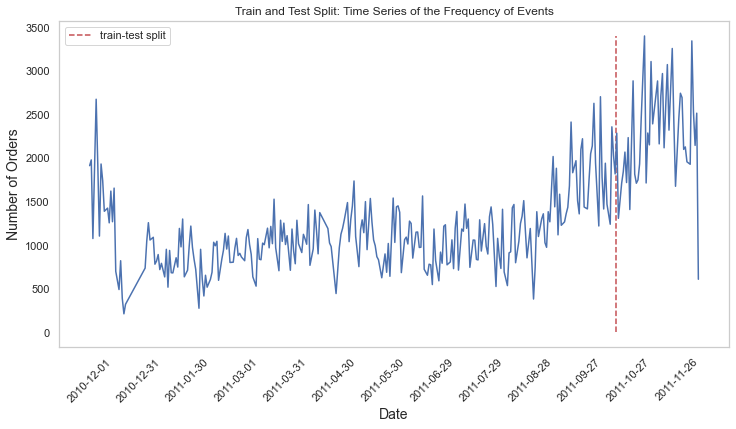

In [39]:
#Visualizing the split made
data_time = pd.DatetimeIndex(data_less_sparse['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))

plt.plot(data_time.index, data_time.values, linestyle="-")
plt.xticks(np.arange(data_time.index[0], data_time.index[-1], pd.to_timedelta(30, unit='d')), rotation=45)
plt.vlines(start_test, 0, data_time.max(), linestyles='dashed', color='r', label='train-test split')
plt.xlabel('Date', size=14)
plt.ylabel('Number of Orders', size=14)
plt.legend()
plt.title('Train and Test Split: Time Series of the Frequency of Events')
plt.grid(False)

plt.show()

### Preparing data to apply the BPR and the BiVAE models

In [40]:
#To apply both the BPR and the BiVAE models, we need to have the dataset in such a way that each line represents the preference for each customer and each product that was purchased by him.
#this is, in the format "CustomerID", "StockCode" and a measure of preference

#we start by copying the dataset
data_less_sparse_clean=data_less_sparse.copy()

#We turn all the Quantitties into 1's, as we will not consider as a measure of interaction the absolute quantity bought, but instead if the item was bought or not in a order
data_less_sparse_clean["Quantity"]=data_less_sparse_clean["Quantity"].apply(lambda x: 1)

#We drop the duplicates, due to the problem referred before:
#If I add 2 units of an item to the cart and then after, only 1 unit, it appears in the dataset/database as 2 separate lines in the same order.
#Thus, we have to delete these duplicates, so we can have only different products per order
data_less_sparse_clean=data_less_sparse_clean.drop_duplicates()

#Separating the data into train and test sets, and selecting only the variables we will use
data_train_not_clean=data_less_sparse_clean[data_less_sparse_clean["train_split"]==1][["CustomerID", "StockCode", "Quantity"]]
data_test_not_clean=data_less_sparse_clean[data_less_sparse_clean["train_split"]==0][["CustomerID", "StockCode", "Quantity"]]

#Getting the Number of orders in which each customer bought a specific item (from the ones he bought)
values_to_add_train=data_train_not_clean.groupby(["CustomerID", "StockCode"])["Quantity"].sum()
values_to_add_test=data_test_not_clean.groupby(["CustomerID", "StockCode"])["Quantity"].sum()

#Creating our final train ans test datasets
data_train=pd.DataFrame(columns=["CustomerID", "StockCode", "Quantity"], index=np.arange(len(values_to_add_train)))
data_test=pd.DataFrame(columns=["CustomerID", "StockCode", "Quantity"], index=np.arange(len(values_to_add_test)))

#Going over the Sums made before and storing the values in the right place, in the format we needed it to be into
for index, row in enumerate(values_to_add_train.index):
    data_train.loc[index, "CustomerID"]=row[0]
    data_train.loc[index, "StockCode"]=row[1]
    data_train.loc[index, "Quantity"]=values_to_add_train[row]

for index, row in enumerate(values_to_add_test.index):
    data_test.loc[index, "CustomerID"]=row[0]
    data_test.loc[index, "StockCode"]=row[1]
    data_test.loc[index, "Quantity"]=values_to_add_test[row]
    

#Changing the types
data_test["CustomerID"]=data_test["CustomerID"].astype(float)
data_test["Quantity"]=data_test["Quantity"].astype(float)

#Creating one train dataset in the format the model receives to be fit.
data_train_set = cornac.data.Dataset.from_uir(data_train.itertuples(index=False), seed=22)


### Preparing Data for ALS model

In [41]:
#Copying the dataset
data_less_sparse_clean=data_less_sparse.copy()

#Making the same change to variable Quantity, as explained above.
data_less_sparse_clean["Quantity"]=data_less_sparse_clean["Quantity"].apply(lambda x: 1)

#Dropping the duplicates, as explained previously.
data_less_sparse_clean=data_less_sparse_clean.drop_duplicates()

#Creating a column to be referent to the test_split.
data_less_sparse_clean["test_split"]=data_less_sparse_clean["train_split"].apply(lambda x: 1 if x==0 else 0)


#We now need to get our data into an item-user matrix, so it can be fed to the ALS model.

#Adapted from: https://github.com/joaopfonseca/business-cases/blob/master/BC4_recommendation_system/BC4_example.ipynb

#Turining our users and items into categories
user_cat = data_less_sparse_clean['CustomerID'].astype('category')
item_cat = data_less_sparse_clean['StockCode'].astype("category")


#We use the column "train_split" as the column which defines the values inputed into the matrix, as this will lead to the train set only to consider the 1's and to sum them as the users and items combinations repeate themselves, which will equal our Preference measure.
item_user_train = coo_matrix((data_less_sparse_clean['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()

#We get the transpose, which is formate necessary to use it in the future, when we want to recommend items
user_item_train = item_user_train.T

#We repeat the same for the test set/matrix
item_user_test = coo_matrix((data_less_sparse_clean['test_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

#checking that each matrix has the same shape
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

#checking that the percentage of zeros is indeed higher in the test set.
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

#Confirming that there are not users without items on both the train and test sets
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

train set shape: (3186, 4074) and test set shape: (3186, 4074)
train set percentage of zeros: 98.41319148791919 and test set percentage of zeros: 99.36159856219265


set()

### Preparing Data for TF-IDF model

In [42]:
# Setting the price for each StockCode, taking into consideration that the same StockCode can have different prices.
#We decided to consider the price which occurs more often.
price1 = data[['StockCode', 'UnitPrice', 'Quantity']].groupby(['StockCode', 'UnitPrice'], as_index=False).count()
price2 = price1.groupby(['StockCode'], as_index=False)['Quantity'].max()
price3 = price2.merge(price1, left_on=['StockCode', 'Quantity'], right_on=['StockCode', 'Quantity'])
price_final = price3.groupby(['StockCode', 'Quantity'], as_index=False)['UnitPrice'].max()

# Setting the description with highest frequency for each StockCode,taking into consideration that the same StockCode can have different descriptions.
description1 = data[['StockCode', 'Description', 'Quantity']].groupby(['StockCode', 'Description'], as_index=False).count()
description2 = description1.groupby(['StockCode'], as_index=False)['Quantity'].max()
description3 = description2.merge(description1, left_on=['StockCode', 'Quantity'], right_on=['StockCode', 'Quantity'])
description_final = description3.groupby(['StockCode', 'Quantity'], as_index=False)['Description'].max()

data_content = description_final.merge(price_final, left_on=['StockCode'], right_on=['StockCode']).drop(columns=['Quantity_x', 'Quantity_y'])

# Add column with price category 
def price_category(df):
    """This function receives a dataframe with a column UnitPrice and catagorizes each value into a certain price category."""
    if df.UnitPrice < 1:
        return 'Price_0'
    elif 1 <= df.UnitPrice < 2:
        return 'Price_1'
    elif 2 <= df.UnitPrice < 3:
        return 'Price_2'
    elif 3 <= df.UnitPrice < 4:
        return 'Price_3'
    elif 4 <= df.UnitPrice < 5:
        return 'Price_4'
    else: 
        return 'Price_5'

#Using the function on our dataframe
data_content['Price_Category'] = data_content.apply(price_category, axis=1)

#Creating a new column with the concatenation of the description and the price category
data_content['All'] = data_content['Description'] + ' ' + data_content['Price_Category']

### Optimizing the Bayesian Personalized Ranking (BPR) model

#### BPR parameters' meaning:

* k: The dimension of the latent factors.
* max_iter – Maximum number of iterations or the number of epochs for SGD.
* learning_rate – The learning rate for SGD.
* lambda_reg – The regularization hyper-parameter.

(from: https://cornac.readthedocs.io/en/latest/models.html#bayesian-personalized-ranking-bpr )

In [43]:
#Creating a dataframe to store the results obtained
df_results_bpr=pd.DataFrame(columns=["parameters","precision_at_k", "recall_at_k", "map_at_k", "ndcg_at_k"])

#an auxilixar variable
index=0

#Creating loops with the different combinations of values chosen to implement.
for nr_int in [250,500]:
    MAX_ITER=nr_int
    for latent_dim in [50,75,100, 125]:
        LATENT_DIM=latent_dim
        for learning_rate in [0.001,0.01]:
            LEARNING_RATE=learning_rate
            for lambda_reg in [0.001,0.0001]:
                LAMBDA_REG= lambda_reg
                
                #creating the model
                bpr = cornac.models.BPR(
                k=LATENT_DIM,
                max_iter=MAX_ITER,
                learning_rate=LEARNING_RATE,
                lambda_reg=LAMBDA_REG,
                verbose=True,
                seed=22)
                
                #fitting the model
                bpr.fit(data_train_set)
                
                #Using the model to predict/recommend
                all_predictions = predict_ranking(bpr, data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)
                
                #Computing the metrics we intend to observe
                precision=precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                map_k = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')

                #storing the results obtained
                df_results_bpr.loc[index, "parameters"]=str(MAX_ITER)+" iterations, "+str(LATENT_DIM)+ " lat_dim, "+str(LEARNING_RATE)+" learn_rate, "+str(LAMBDA_REG)+" Lambda_Reg"
                df_results_bpr.loc[index, "precision_at_k"]=precision
                df_results_bpr.loc[index, "recall_at_k"]=recall
                df_results_bpr.loc[index, "map_at_k"]=map_k
                df_results_bpr.loc[index, "ndcg_at_k"]=ndcg
                index+=1


Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!



Optimization finished!


In [44]:
#Checking the results, sorting by the MAP at K measure, giving it is the one we consider most important
df_results_bpr.sort_values(by="map_at_k", ascending=False).head()

,parameters,precision_at_k,recall_at_k,map_at_k,ndcg_at_k
14,"250 iterations, 125 lat_dim, 0.01 learn_rate, ...",0.0683073,0.0239867,0.0107051,0.0747799
15,"250 iterations, 125 lat_dim, 0.01 learn_rate, ...",0.0658463,0.0231644,0.0105739,0.0735837
10,"250 iterations, 100 lat_dim, 0.01 learn_rate, ...",0.0656663,0.0238219,0.0103916,0.0738246
30,"500 iterations, 125 lat_dim, 0.01 learn_rate, ...",0.0662065,0.0247861,0.0103404,0.0732054
11,"250 iterations, 100 lat_dim, 0.01 learn_rate, ...",0.0654262,0.0237109,0.0102821,0.0732419


In [45]:
#Storing the results in an excel, so we can access it.
df_results_bpr.to_excel("results_bpr.xlsx")

### Optimizing the Bilateral VAE for Collaborative Filtering (BiVAECF) model

#### BiVAE parameters' meaning:

* k – The dimension of the stochastic user theta and item beta factors.
* encoder_structure – The number of neurons per layer of the user and item encoders for BiVAE. For example, encoder_structure = [20], the user (item) encoder structure will be [num_items, 20, k] ([num_users, 20, k]).
* act_fn – Name of the activation function used between hidden layers of the auto-encoder. 
* likelihood – The likelihood function used for modeling the observations.
* n_epochs – The number of epochs for SGD.
* batch_size – The batch size.
* learning_rate – The learning rate for Adam.
* beta_kl – The weight of the KL terms as in beta-VAE.

(from: https://cornac.readthedocs.io/en/latest/models.html#module-cornac.models.bivaecf.recom_bivaecf )

In [47]:
#Creating a dataframe to store the results
df_results_bivae=pd.DataFrame(columns=["parameters","precision_at_k", "recall_at_k", "map_at_k", "ndcg_at_k"])
index=0

#Creating loops to go over the values for each parameter we want to test.
for nr_epoch in [100]:
    NUM_EPOCHS=nr_epoch
    for latent_dim in [10,50,100]:
        LATENT_DIM = latent_dim
        for encoder_dim in [[20], [50]]:
            ENCODER_DIMS=encoder_dim
            for act_func in [ 'tanh']:
                ACT_FUNC=act_func
                for like in ["pois"]:
                    LIKELIHOOD=like
                    for batch in [128]:
                        BATCH_SIZE=batch
                        for learn_rate in [0.01,0.001]:
                            LEARNING_RATE=learn_rate
                            for beta in [1, 1.5]:
                                BETA=beta
                            
                                #Creating the model
                                bivae = cornac.models.BiVAECF(
                                k=LATENT_DIM,
                                encoder_structure=ENCODER_DIMS,
                                act_fn=ACT_FUNC,
                                likelihood=LIKELIHOOD,
                                n_epochs=NUM_EPOCHS,
                                batch_size=BATCH_SIZE,
                                learning_rate=LEARNING_RATE,
                                beta_kl=BETA,
                                seed=22,
                                use_gpu=True,
                                verbose=True
                                )
                               
                                #Fitting the model
                                bivae.fit(data_train_set)
                            
                                #computing the predictions/recommendations
                                all_predictions = predict_ranking(bivae, data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)
                            
                                #Computing the measures we intend to analyse
                                precision=precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                                map_k = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                                ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                                recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                            
                                #Storing the results
                                df_results_bivae.loc[index, "parameters"]=str(NUM_EPOCHS)+" epochs,"+str(LATENT_DIM)+ " lat_dim, "+ str(ENCODER_DIMS)+" enc_dims, "+str(ACT_FUNC)+" act_func, "+str(LIKELIHOOD)+ " like, "+str(BATCH_SIZE)+" batch_size, "+str(LEARNING_RATE)+" learn_rate"+str(BETA)+" beta"
                                df_results_bivae.loc[index, "precision_at_k"]=precision
                                df_results_bivae.loc[index, "recall_at_k"]=recall
                                df_results_bivae.loc[index, "map_at_k"]=map_k
                                df_results_bivae.loc[index, "ndcg_at_k"]=ndcg
                                index+=1

In [48]:
#Seeing the results, sorting by the measure we are most interest in: MAP at K
df_results_bivae.sort_values(by="map_at_k", ascending=False).head()

,parameters,precision_at_k,recall_at_k,map_at_k,ndcg_at_k
15,"100 epochs,50 lat_dim, [50] enc_dims, tanh act...",0.0606843,0.020975,0.00856711,0.0663851
14,"100 epochs,50 lat_dim, [50] enc_dims, tanh act...",0.0566627,0.0205089,0.00847121,0.0616349
23,"100 epochs,100 lat_dim, [50] enc_dims, tanh ac...",0.0547419,0.018689,0.00784298,0.0596498
6,"100 epochs,10 lat_dim, [50] enc_dims, tanh act...",0.0546819,0.0190879,0.00771826,0.0597702
21,"100 epochs,100 lat_dim, [50] enc_dims, tanh ac...",0.0562425,0.0193938,0.00743504,0.0592843


In [49]:
#Stroing the results in an excel, so we can access them
df_results_bivae.to_excel("results_bivae100epochs.xlsx")

### Optimizing the Alternating Least Squares (ALS) model

#### ALS parameters' meaning:

* factors – The number of latent factors to compute
* regularization – The regularization factor to use
* iterations – The number of ALS iterations to use when fitting data
* alpha - Rate of increase in Preference.

(from: https://implicit.readthedocs.io/en/latest/als.html  and http://yifanhu.net/PUB/cf.pdf)

In [59]:
#Due to changes in the calculation of the Precison (and consequently, MAP at K) metric in the Implicit librabry (https://github.com/benfred/implicit/issues/158), and considering we want our results to be compared over models, we could not use Implicit's evaluation metrics.
#Being this said, we were "forced" to apply the ALS to our train set, use its ability to Recommend, and then putting the results in the same format which was required for the BiVAE and BPR models, so we can apply the same evaluation metrics.
#Note, once more, that althought not supposed to, the method Recommend is by default recommending items which the users have already seem in the train set, so we also had to deal "manually" with this issue.

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

#Creating a dataframe to store the results
df_results_als=pd.DataFrame(columns=["parameters","precision_at_k", "recall_at_k", "map_at_k", "ndcg_at_k"])
index=0

#Creating loops to iterate over the values for all the parameters
for alpha in [1.5,3,15,40]:
    ALPHA=alpha
    for factors in [50, 150, 200]:
        FACTORS=factors
        for reg in [0.05, 0.01,0.001]:
            REG=reg
            for inter in [200, 500]:
                INTERACTIONS=inter
                
                #Creating the model
                als_model = AlternatingLeastSquares(factors=FACTORS, regularization=REG, iterations=INTERACTIONS, random_state=22)
                
                #Fitting the model
                als_model.fit((item_user_train * ALPHA).astype('double'))
                
                #Creating the dataframe where we will store the model's predictions
                als_all_predictions=pd.DataFrame(columns=["CustomerID","StockCode", "prediction"])
                
                
                #for each user in the train set, we have to see which items he bought (in the train set) ans store their Ids.
                #Then, we use the ALS to recommend the necessary number of products so we can have a margin of 11 products not seen yet (meaning that we make sure that we will always have 10 products suggested that the customer have not seen yet in the train set)
                #We select the 10 most recommended which have not been seen yet and store those predictions.
                #In the end, we have 10 suggestions to each user in the train set.
                i=0
                for user_id in data_train["CustomerID"].unique():
                    cust_prods=data_train[data_train["CustomerID"]==user_id]["StockCode"].unique()
                    recommendations = als_model.recommend(user_map[user_id], user_item_train, N=len(cust_prods)+11)
                    preds=list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))
                    preds_final=[i[0] for i in preds if i[0] not in cust_prods][:10][::-1]
                    for ind, pred in enumerate(preds_final):
                        als_all_predictions.loc[i,"CustomerID"]=user_id
                        als_all_predictions.loc[i,"StockCode"]=pred
                        als_all_predictions.loc[i,"prediction"]=ind+1
                        i+=1
                 
                
                #Changing the types
                als_all_predictions["CustomerID"]=als_all_predictions["CustomerID"].astype(float)
                als_all_predictions["prediction"]=als_all_predictions["prediction"].astype(float)
                
                #Calculating the evaluation metrics we are interested in
                map_k = map_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
                ndcg = ndcg_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                precision = precision_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                recall = recall_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
                
                #storing the results
                df_results_als.loc[index, "parameters"]=str(INTERACTIONS)+" interactions, "+str(FACTORS)+ " factors, "+ str(REG)+" regularization, "+str(ALPHA)+" alpha"
                df_results_als.loc[index, "precision_at_k"]=precision
                df_results_als.loc[index, "recall_at_k"]=recall
                df_results_als.loc[index, "map_at_k"]=map_k
                df_results_als.loc[index, "ndcg_at_k"]=ndcg
                index+=1

In [60]:
#Checking the results, sorting by MAP at K, giving it is the most important metric for us
df_results_als.sort_values(by="map_at_k", ascending=False).head()

,parameters,precision_at_k,recall_at_k,map_at_k,ndcg_at_k
19,"500 interactions, 50 factors, 0.05 regularizat...",0.0785114,0.0289953,0.0130126,0.0872064
20,"200 interactions, 50 factors, 0.01 regularizat...",0.0777911,0.0290057,0.0129606,0.0863639
22,"200 interactions, 50 factors, 0.001 regulariza...",0.0780912,0.0289096,0.0129585,0.0866421
18,"200 interactions, 50 factors, 0.05 regularizat...",0.0780912,0.0288418,0.0129104,0.0863681
4,"200 interactions, 50 factors, 0.001 regulariza...",0.0801321,0.0288014,0.0128924,0.088457


In [61]:
#Storing the results in an excel, so we can acess them
df_results_als.to_excel("results_als.xlsx")

### Applying the BPR model

In [62]:
#Please note that as said on the Report, we will apply our models to recommend products in two ways:
#1. To recommend items that the user has never seen before
#2. To recommend items independently if the user has seen then before or not.

#Creating 2 dictionaries to store the results obtained for each model.
eval_not_removing_seen={}
eval_removing_seen={}

In [63]:
#Creating the model with the best parameters
bpr = cornac.models.BPR(
    k=125,
    max_iter=250,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=22
)

#Fitting the data to the model
bpr.fit(data_train_set)

#Creating the predictions and the metric evaluations for the case were we don't recommend products seen before by the user.
#Note that here this can be easily done by using the parameter "remove_seen"
all_predictions = predict_ranking(bpr, data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)
eval_map = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')

#Storing the results
eval_removing_seen["BPR"]=(eval_map, eval_ndcg, eval_precision, eval_recall)


#Creating the predictions and the metric evaluations for the case were we recommend products independtly of the user having seen them before or not.
all_predictions = predict_ranking(bpr, data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=False)
eval_map = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')

#storing the results
eval_not_removing_seen["BPR"]=(eval_map, eval_ndcg, eval_precision, eval_recall)


Optimization finished!


### Applying the BiVAE model

In [64]:
#Creating the model with the best parameters
bivae = cornac.models.BiVAECF(
    k=50,
    encoder_structure=[50],
    act_fn="tanh",
    likelihood="pois",
    n_epochs=100,
    batch_size=128,
    learning_rate=0.001,
    seed=22,
    beta_kl = 1.5,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)

#Fitting the train set to the model
bivae.fit(data_train_set)


#Creating the predictions and the metric evaluations for the case were we don't recommend products seen before by the user.
#Note that here this can be easily done by using the parameter "remove_seen"
all_predictions = predict_ranking(bivae,  data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=True)
eval_map = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')

#Storing the results
eval_removing_seen["BIVAE"]=(eval_map, eval_ndcg, eval_precision, eval_recall)


#Creating the predictions and the metric evaluations for the case were we recommend products independtly of the user having seen them before or not.
all_predictions = predict_ranking(bivae,  data_train, usercol='CustomerID', itemcol='StockCode', remove_seen=False)
eval_map = map_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')

#Storing the results
eval_not_removing_seen["BIVAE"]=(eval_map, eval_ndcg, eval_precision, eval_recall)

### Applying the ALS model

In [67]:
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

#Creating the model with the best parameters
alpha = 3
als_model = AlternatingLeastSquares(factors=50, regularization=0.05, iterations=500, random_state=22)

#fitting the model to the train set
als_model.fit((item_user_train * alpha).astype('double'))

#As explained before, for the ALS' case, we have to compute the predictions "at hand"


#Starting by the cases where we don't recommend items already seen by the user

#The steps are the same as seen before, in the optimization phase.
als_all_predictions=pd.DataFrame(columns=["CustomerID","StockCode", "prediction"])

i=0
for user_id in data_train["CustomerID"].unique():
    cust_prods=data_train[data_train["CustomerID"]==user_id]["StockCode"].unique()
    recommendations = als_model.recommend(user_map[user_id], user_item_train, N=len(cust_prods)+11)
    preds=list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))
    preds_final=[i[0] for i in preds if i[0] not in cust_prods][:10]
    values_scores=[i[1] for i in preds if i[0] in preds_final]
    for ind, pred in enumerate(preds_final):
        als_all_predictions.loc[i,"CustomerID"]=user_id
        als_all_predictions.loc[i,"StockCode"]=pred
        als_all_predictions.loc[i,"prediction"]=values_scores[ind]
        i+=1

#Changing the types                 
als_all_predictions["CustomerID"]=als_all_predictions["CustomerID"].astype(float)
als_all_predictions["prediction"]=als_all_predictions["prediction"].astype(float)

#Calculating the metrics for this case and storing the results
eval_map = map_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_removing_seen["ALS"]=(eval_map, eval_ndcg, eval_precision, eval_recall)


#Now, in the case where we recommend products independtly of a user having seen them before or not, considering it is the default output of the Recommend method, we can just apply it directly and store its results

als_all_predictions=pd.DataFrame(columns=["CustomerID","StockCode", "prediction"])

i=0
for user_id in data_train["CustomerID"].unique():
    recommendations = als_model.recommend(user_map[user_id], user_item_train)
    preds=list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))
    for pred in preds:
        als_all_predictions.loc[i,"CustomerID"]=user_id
        als_all_predictions.loc[i,"StockCode"]=pred[0]
        als_all_predictions.loc[i,"prediction"]=pred[1]
        i+=1

#Changing the types   
als_all_predictions["CustomerID"]=als_all_predictions["CustomerID"].astype(float)
als_all_predictions["prediction"]=als_all_predictions["prediction"].astype(float)

#Calculating the metrics and storing the results
eval_map = map_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, als_all_predictions, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_not_removing_seen["ALS"]=(eval_map, eval_ndcg, eval_precision, eval_recall)

### Applying the Most Popular model

In [65]:
#To compute the Most Popular items, we have to make some changes to get them:

#copying the dataset
data_less_sparse_clean=data_less_sparse.copy()

#As before, truning all quantities into 1's and thus dropping the duplicates
data_less_sparse_clean["Quantity"]=data_less_sparse_clean["Quantity"].apply(lambda x: 1)
data_less_sparse_clean=data_less_sparse_clean.drop_duplicates()

#Going to the train set and seeing which are the products present in most orders
data_clean_train=data_less_sparse_clean[data_less_sparse_clean["train_split"]==1][["CustomerID", "StockCode", "Quantity"]]
top_products=data_clean_train.groupby("StockCode").sum().sort_values("Quantity")[::-1].index.values

#For the case where we will recommend the most popular products, independtly of the user:

#We get the top 10 products
ranking_products_10=dict(zip(top_products[:10], np.arange(1,len(top_products[:10])+1)[::-1]))

#We, once more, store the predictions (the 10 products) in the format needed to be used by the evaluation metrics
all_predictions_pop=pd.DataFrame(columns=["CustomerID", "StockCode", "prediction"])
index=0
for custId in data_train["CustomerID"].unique():
    for code,pred in ranking_products_10.items():
        all_predictions_pop.loc[index, "CustomerID"]=custId
        all_predictions_pop.loc[index, "StockCode"]=code
        all_predictions_pop.loc[index, "prediction"]=pred
        index+=1

#changing the types
all_predictions_pop["CustomerID"]=all_predictions_pop["CustomerID"].astype(float)
all_predictions_pop["prediction"]=all_predictions_pop["prediction"].astype(float)

#computing the evaluation metrics and storing the results
eval_map = map_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_not_removing_seen["POP"]=(eval_map, eval_ndcg, eval_precision, eval_recall)

#Now, for the case where we want to recommend the most popular products, but doing so without recommending products the user has seen before:

#Creating a dataframe to store the predictions in the right format
all_predictions_pop=pd.DataFrame(columns=["CustomerID", "StockCode", "prediction"])
index=0

#Going over each user present in the train set, finding the products he has already bought and removing those from the list which contains the most bought products.
#Then, from the remaining, we chose the best 10.
for custId in data_train["CustomerID"].unique():
    cust_prods=data_train[data_train["CustomerID"]==custId]["StockCode"].unique()
    top_products_cust=[i for i in top_products if i not in cust_prods]
    ranking_products_10=dict(zip(top_products_cust[:10], np.arange(1,len(top_products_cust[:10])+1)[::-1]))
    for code,pred in ranking_products_10.items():
        all_predictions_pop.loc[index, "CustomerID"]=custId
        all_predictions_pop.loc[index, "StockCode"]=code
        all_predictions_pop.loc[index, "prediction"]=pred
        index+=1

#changing the types
all_predictions_pop["CustomerID"]=all_predictions_pop["CustomerID"].astype(float)
all_predictions_pop["prediction"]=all_predictions_pop["prediction"].astype(float)

#Calcuçating the evaluation metrics and storing the results
eval_map = map_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity' )
eval_ndcg = ndcg_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_precision = precision_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_recall = recall_at_k(data_test, all_predictions_pop, col_prediction='prediction', k=10, col_user="CustomerID", col_item="StockCode",col_rating='Quantity')
eval_removing_seen["POP"]=(eval_map, eval_ndcg, eval_precision, eval_recall)

### Applying the TF-DIF model

In [66]:
#Initializing the model
tfidf = TfidfVectorizer()
mapping = pd.Series(data_content.index, index = data_content['StockCode'])

def content_recommend_products(products_input): 
    """This function receives a list of StockCode's and recurring to the TF-DIF model finds the most similar products, never bought by the user.
    Note that it takes into consideration also the price category of each product.
    If a customer has bought more than 1 item, and therefore, you pass a list with more than 1 item, the model also considers the whole purchasing history as 'one'.
    Be aware that this function was constructed for a specific purpose, and thus it can only take as input a list with up to 4 items (inclusive)."""
    
    #Accessing only the unique products bought by the user
    products_input = list(set(products_input))
    
    #List with concatenated string and input products index, to not be returned 
    product_index = [len(data_content)]
    for i in range(len(products_input)):
        product_index.append(mapping[products_input[i]])    
            
    # With only 1 product, we don't need to take into consideration any more items
    if len(products_input) == 1:
        all_matrix = tfidf.fit_transform(data_content['All'])
        
        #getting the similarity scores, using the cosine similarity
        similarity_matrix = cosine_similarity(all_matrix, all_matrix)
        
        product_index = mapping[products_input[0]]
        
        #finding the 10 products with higher similarity score
        similarity_score = list(enumerate(similarity_matrix[product_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[1:11]

        product_indices = [i[0] for i in similarity_score]
        
        return (data_content['StockCode'].iloc[product_indices]).tolist() 
        
    # After more than 1 item purchased, we consider all the items as one, so there's the need to concatenate all the strings and then add it to the dataframe to be fed to the model.
    #Other than that, the process is the same as before.
    elif 5 > len(products_input) > 1:           
        for i in range(len(products_input)):
            if i == 0:
                prod_concat = data_content.All.iloc[mapping[products_input[i]]] 
            else:
                prod_concat = prod_concat + ' ' + data_content.All.iloc[mapping[products_input[i]]]
        
        # Add input products concatenated 
        data_without_products_input = data_content['All'].append(pd.Series(prod_concat, index=[len(data_content)]))
        
        all_matrix = tfidf.fit_transform(data_without_products_input)
        
        similarity_matrix = cosine_similarity(all_matrix, all_matrix)

        similarity_score = list(enumerate(similarity_matrix[-1]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        
        product_indices = [i[0] for i in similarity_score]
        product_indices = [x for x in product_indices if x not in product_index]
        
        return (data_content['StockCode'].iloc[product_indices[:10]]).tolist()        

    else:
        print('The number of input products must be 1, 2, 3 or 4')

## Comparing Results

In [68]:
#Comparing the Results obatined for the case where we don't recommend products already seen by the User
#Note that the values are already in percentage
evaluation_metrics_df_no_seen = pd.DataFrame(eval_removing_seen).T.rename(columns={0:"MAP", 1:"NDCG", 2:"Precision", 3:"Recall"})*100
evaluation_metrics_df_no_seen= evaluation_metrics_df_no_seen.sort_values("MAP", ascending=False)


#Comparing the Results obatined for the case where we recommend products independently of a user having seen them already
#Note that the values are already in percentage
evaluation_metrics_df_seen = pd.DataFrame(eval_not_removing_seen).T.rename(columns={0:"MAP", 1:"NDCG", 2:"Precision", 3:"Recall"})*100

evaluation_metrics_df_seen= evaluation_metrics_df_seen.sort_values("MAP", ascending=False)


In [69]:
evaluation_metrics_df_seen

,MAP,NDCG,Precision,Recall
ALS,6.881215,26.685047,24.195678,11.601598
BPR,5.479495,23.440967,21.296519,9.954017
BIVAE,3.006021,17.004193,15.846339,6.262884
POP,1.259209,10.008353,9.063625,2.976163


In [70]:
evaluation_metrics_df_no_seen

,MAP,NDCG,Precision,Recall
ALS,1.301262,8.720635,7.851140,2.899526
BPR,1.070507,7.477987,6.830732,2.398669
BIVAE,0.855389,6.630311,6.062425,2.093969
POP,0.424387,3.635823,3.391357,1.092110


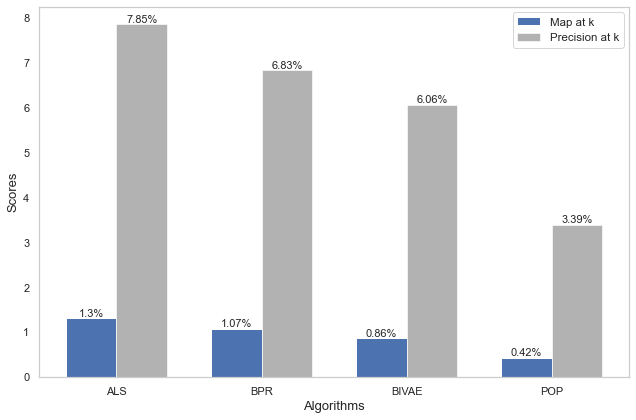

In [71]:
#Plotting the Precision at K and MAP at K for the cases where we don't recommend products already seen by the user.

models = evaluation_metrics_df_no_seen.index.to_list()
map_at_k = list(evaluation_metrics_df_no_seen.MAP.values)
precision_at_k = list(evaluation_metrics_df_no_seen.Precision.values)

x_axis = np.arange(len(models))  
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(9)

bar_map = ax.bar(x_axis - width/2, map_at_k, width, label='Map at k')
bar_precision = ax.bar(x_axis + width/2, precision_at_k, width, label='Precision at k', color='grey', alpha=0.6)

ax.set_ylabel('Scores', size=13)
ax.set_xlabel('Algorithms', size=13)
ax.set_xticks(x_axis)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11.5)

for rect in bar_map:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(height,2)) + '%', ha='center', va='bottom', fontsize=11)

for rect in bar_precision:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(height,2)) + '%', ha='center', va='bottom', fontsize=11)
ax.grid(False)

fig.tight_layout()

plt.show()

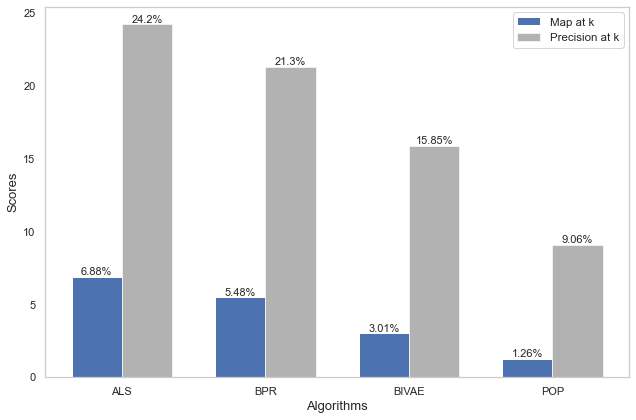

In [72]:
#Plotting the Precision at K and MAP at K for the cases where we recommend products independently of the user having seem them before or not.


models = evaluation_metrics_df_seen.index.to_list()
map_at_k = list(evaluation_metrics_df_seen.MAP.values)
precision_at_k = list(evaluation_metrics_df_seen.Precision.values)

x_axis = np.arange(len(models))  
width = 0.35

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(9)

bar_map = ax.bar(x_axis - width/2, map_at_k, width, label='Map at k')
bar_precision = ax.bar(x_axis + width/2, precision_at_k, width, label='Precision at k', color='grey', alpha=0.6)

ax.set_ylabel('Scores', size=13)
ax.set_xlabel('Algorithms', size=13)
ax.set_xticks(x_axis)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11.5)

for rect in bar_map:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(height,2)) + '%', ha='center', va='bottom', fontsize=11)

for rect in bar_precision:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(round(height,2)) + '%', ha='center', va='bottom', fontsize=11)

fig.tight_layout()
ax.grid(False)
plt.show()

# Training the Model with all data

In [73]:
#Repeating the same process we did before, but now we don't have the need to make any split between test and train sets.

data_less_sparse_clean=data_less_sparse.copy()
data_less_sparse_clean["Quantity"]=data_less_sparse_clean["Quantity"].apply(lambda x: 1)
data_less_sparse_clean=data_less_sparse_clean.drop_duplicates()

user_cat = data_less_sparse_clean['CustomerID'].astype('category')
item_cat = data_less_sparse_clean['StockCode'].astype("category")

#The only change is here, where we use the Quantity variable, considering we now don't have the need to split between test and train
item_user = coo_matrix((data_less_sparse_clean['Quantity'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user.eliminate_zeros()  
user_item = item_user.T

user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

alpha = 3
als_model = AlternatingLeastSquares(factors=50, regularization=0.05, iterations=500, random_state=22)
als_model.fit((item_user * alpha).astype('double'))


als_final_predictions=pd.DataFrame(columns=["CustomerID","StockCode", "prediction"])

i=0
for user_id in data_less_sparse.CustomerID.unique():
    cust_prods=data_less_sparse[data_less_sparse["CustomerID"]==user_id]["StockCode"].unique()
    recommendations = als_model.recommend(user_map[user_id], user_item, N=len(cust_prods)+11)
    preds=list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))
    preds_final=[i[0] for i in preds if i[0] not in cust_prods][:10]
    values_scores=[i[1] for i in preds if i[0] in preds_final]
    for ind, pred in enumerate(preds_final):
        als_final_predictions.loc[i,"CustomerID"]=user_id
        als_final_predictions.loc[i,"StockCode"]=pred
        als_final_predictions.loc[i,"prediction"]=values_scores[ind]
        i+=1

In [74]:
#Computing the most popular items for all the database, not only for the data_less_sparse one.
data_clean=data.copy()
data_clean["Quantity"]=data_clean["Quantity"].apply(lambda x: 1)
data_clean=data_clean.drop_duplicates()
top_products_final=data_clean.groupby("StockCode").sum().sort_values("Quantity")[::-1].index.values